In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, concatenate, Dense, BatchNormalization, Lambda, TimeDistributed, Dot, dot
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
from os.path import expanduser, exists

import datetime
import time

In [12]:
!pip install hyperdash
from hyperdash import monitor_cell
import json

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 78.2/78.2 kB 1.4 MB/s eta 0:00:00
  Created wheel for hyperdash: filename=hyperdash-0.15.3-py3-none-any.whl size=28540 sha256=46242449d53f0fadb510229186966a007b6a5ff46e9c014bb4b0836dce008fb0
  Stored in directory: c:\users\kusha\appdata\local\pip\cache\wheels\c4\81\b7\d2f1793af02103e7fed6df39b349274d8e8114ff9f7a1270f5
Successfully built hyperdash



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Cleaning and Analysis

In [13]:
train_data = pd.read_csv('train.csv')
train_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
363856,363856,493886,104093,Is there anyone from Mumbai preparing for UPSC?,Union Public Service Commission (India): What ...,0
363857,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0
363858,363858,14695,44317,How can I lose weight effectively?,How do I lose weight without stopping?,1
363859,363859,12342,493889,Why are old TV shows square shaped on modern s...,Why are computer and TV screens typically squa...,0


In [14]:
train_df = train_data.copy()

In [15]:
q1_set = set(train_df['question1'].unique())
q2_set = set(train_df['question2'].unique())
all_ques = q1_set | q2_set
len(all_ques)

493391

In [17]:
q1_list = train_df['question1'].tolist()
q2_list = train_df['question2'].tolist()
q1_list = [str(que) for que in q1_list]
q2_list = [str(que) for que in q2_list]
is_duplicate = train_df['is_duplicate'].tolist()

print(q1_list[0], ':', q2_list[0], ':', is_duplicate[0])

What is the step by step guide to invest in share market in india? : What is the step by step guide to invest in share market? : 0


In [19]:
all_ques = q1_list + q2_list
tokenizer = Tokenizer(num_words = 100000)
tokenizer.fit_on_texts(all_ques)

In [20]:
q1_seq = tokenizer.texts_to_sequences(q1_list)
q2_seq = tokenizer.texts_to_sequences(q2_list)
word_index = tokenizer.word_index

print(f'Words in index : {len(word_index)}')

Words in index : 91013


In [21]:
dictionary = word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

In [23]:
GLOVE_DOWNLOAD_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'

if not exists(expanduser('~/.keras/datasets/glove.840B.300d.zip')):
    zipfile = ZipFile(utils.get_file('glove.840B.300d.zip', GLOVE_DOWNLOAD_URL))
    zipfile.extract('glove.840B.300d.txt', path=expanduser('~/.keras/datasets/'))


2176768927/2176768927 [==============================] - 4295s 2us/step


In [27]:
embeddings_index = {}
with open(expanduser('~/.keras/datasets/glove.840B.300d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print(f'Word embeddings : {len(embeddings_index)}')

Word embeddings : 2196016


In [28]:
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300

nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print(f'Null Word Embeddings : {np.sum(np.sum(word_embedding_matrix, axis=1)==0)}')

Null Word Embeddings : 27053


In [29]:
q1_seq[0:5]

[[2, 3, 1, 1245, 57, 1245, 2546, 7, 577, 8, 772, 379, 8, 35],
 [2, 3, 1, 562, 10, 13509, 14684, 5, 21439, 4449],
 [4, 13, 5, 219, 1, 439, 10, 17, 364, 1848, 205, 146, 6, 2836],
 [16, 72, 5, 2693, 309, 2764, 4, 13, 5, 661, 19],
 [23, 49, 7202, 8, 233, 33752, 1906, 2077, 10473, 12, 1927, 10671, 6462]]

In [30]:
max_seq_len = 0
for ques in q1_seq:
    if(len(ques)>max_seq_len_len):
        max_seq_len = len(ques)
max_seq_len

127

In [33]:
MAX_SEQUENCE_LENGTH = 130

q1_data = pad_sequences(q1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_seq, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(is_duplicate, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (363861, 130)
Shape of question2 data tensor: (363861, 130)
Shape of label tensor: (363861,)


In [35]:
q1_data[0:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     2,
            3,     1,  1245,    57,  1245,  2546,     7,   577,     8,
      

In [36]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X.shape

(363861, 2, 130)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]
Q1_train.shape

(254702, 130)

In [38]:
Q1_train

array([[   0,    0,    0, ...,   14,  128,  785],
       [   0,    0,    0, ...,  180, 1670,  161],
       [   0,    0,    0, ..., 1453, 1346, 7721],
       ...,
       [   0,    0,    0, ...,   35,   12,   16],
       [   0,    0,    0, ...,   14, 2047, 6171],
       [   0,    0,    0, ...,    6, 2924, 6972]])

## Model

In [50]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 130, 300)     27304200    ['input_5[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 130, 300)     27304200    ['input_6[0][0]']                
                                                                                            

In [49]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [41]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [52]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint('question_pairs_weights.h5', monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=10,
                    validation_data=([Q1_test, Q2_test], y_test),
                    verbose=2,
                    batch_size=64,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2023-03-19 08:22:43.317122
Epoch 1/10
3980/3980 - 684s - loss: 0.5410 - accuracy: 0.7247 - val_loss: 0.4893 - val_accuracy: 0.7562 - 684s/epoch - 172ms/step
Epoch 2/10
3980/3980 - 641s - loss: 0.4881 - accuracy: 0.7587 - val_loss: 0.4990 - val_accuracy: 0.7465 - 641s/epoch - 161ms/step
Epoch 3/10
3980/3980 - 643s - loss: 0.4588 - accuracy: 0.7776 - val_loss: 0.4545 - val_accuracy: 0.7778 - 643s/epoch - 162ms/step
Epoch 4/10
3980/3980 - 647s - loss: 0.4335 - accuracy: 0.7936 - val_loss: 0.5279 - val_accuracy: 0.7389 - 647s/epoch - 163ms/step
Epoch 5/10
3980/3980 - 631s - loss: 0.4128 - accuracy: 0.8054 - val_loss: 0.4421 - val_accuracy: 0.7836 - 631s/epoch - 159ms/step
Epoch 6/10
3980/3980 - 649s - loss: 0.3949 - accuracy: 0.8164 - val_loss: 0.4339 - val_accuracy: 0.7882 - 649s/epoch - 163ms/step
Epoch 7/10
3980/3980 - 648s - loss: 0.3770 - accuracy: 0.8265 - val_loss: 0.4220 - val_accuracy: 0.7979 - 648s/epoch - 163ms/step
Epoch 8/10
3980/3980 - 701s - loss: 0.3630

## Evaluation

In [53]:
from keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt

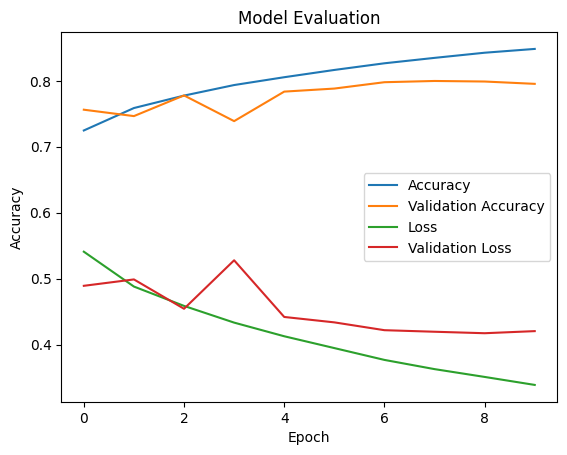

In [54]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

## Predictions

In [55]:
def convert_text_to_index_array(text, dictionary):
    words = text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])
        else:
            print("'%s' not in training corpus; ignoring." %(word))
    return wordIndices

In [56]:
question1 = "What's r programming?"
question2 = "What's in r programming?"

q1_word_seq = convert_text_to_index_array(question1,dictionary)
q1_word_seq = [q1_word_seq]
q2_word_seq = convert_text_to_index_array(question2,dictionary)
q2_word_seq = [q2_word_seq]
q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict([q1_data,q2_data])
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.5865488]]


In [57]:
question1 = "How to learn english?"
question2 = "Why can't I dance?"

q1_word_seq = convert_text_to_index_array(question1,dictionary)
q1_word_seq = [q1_word_seq]
q2_word_seq = convert_text_to_index_array(question2,dictionary)
q2_word_seq = [q2_word_seq]
q1_data = pad_sequences(q1_word_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_word_seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict([q1_data,q2_data])
print(pred)

1/1 [==============================] - 0s 226ms/step
[[0.04906398]]
